# Validate Results

In [1]:
import os
import sys
import warnings
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

warnings.filterwarnings('ignore')
sys.path.insert(0, os.path.abspath(os.path.join(os.path.dirname('src'), '..')))

from src.logger import log
from src.constants import *
from src.data import torus, preprocess, get_all_datasets
from src.missingness import MISSINGNESS
from src.tda import TDA
from src.normalize import normalize_by_diameter
from src.visualize import *
from src.statistical_analysis import test_against_baseline

In [2]:
datasets = get_all_datasets()

for key, dataset in datasets.items():
    assert isinstance(dataset[TARGET], np.ndarray), f'{key}: Target must be a numpy array'
    assert np.issubdtype(dataset[TARGET].dtype, np.number), f'{key}: Target must be numeric'
    assert isinstance(dataset[DATA], pd.DataFrame), f'{key}: Data must be a pandas DataFrame'
    assert all(np.issubdtype(dtype, np.number) for dtype in dataset[DATA].dtypes), f'{key}: All features in Data must be numeric'
    assert not dataset[DATA].isnull().values.any(), f'{key}: Data must not contain missing values'
    assert np.allclose(dataset[DATA].mean(axis=0), 0, atol=1e-6), f'{key}: Mean of every feature should be close to 0'
    assert np.allclose(dataset[DATA].std(axis=0, ddof=0), 1, atol=1e-6), f'{key}: Standard deviation of every feature should be close to 1'

## Introduced Missing Rate
Check wether the proportion of missing values in each dataset matches the desired missing rate

In [3]:
missing_rates = [1, 2, 3, 4, 5, 6, 8, 10, 15, 20, 25, 30, 40]
for id, dataset in datasets.items():
    for missing_rate in missing_rates:
        data_miss = {
            MCAR: MISSINGNESS[MCAR][FUNCTION](dataset[DATA], dataset[TARGET], missing_rate, SEEDS[0]),
            MAR: MISSINGNESS[MAR][FUNCTION](dataset[DATA], dataset[TARGET], missing_rate, SEEDS[0]),
            MNAR: MISSINGNESS[MNAR][FUNCTION](dataset[DATA], dataset[TARGET], missing_rate, SEEDS[0])
        }
        for key, value in data_miss.items():
            assert (missing_rate / 100) == round(value.isna().sum().sum() / value.size, 3), f'Missing rate {missing_rate}% not achieved for {key} in {LABEL[id]}'
    log(f'Missing data in {LABEL[id]} created successfully.')

[2025-09-29 17:39:50] | Missing data in Stock Dataset created successfully.
[2025-09-29 17:40:17] | Missing data in RMFTSA LA Data created successfully.
[2025-09-29 17:40:44] | Missing data in Concrete Data created successfully.
[2025-09-29 17:41:11] | Missing data in Debutanizer created successfully.
[2025-09-29 17:41:37] | Missing data in Treasury created successfully.
[2025-09-29 17:42:04] | Missing data in Weather Izmir created successfully.
[2025-09-29 17:42:32] | Missing data in Hungarian Chickenpox created successfully.
[2025-09-29 17:42:59] | Missing data in CNN Stock Prediction DJI created successfully.
[2025-09-29 17:43:25] | Missing data in Diabetes Dataset created successfully.
[2025-09-29 17:43:52] | Missing data in Indian Stock Market created successfully.
[2025-09-29 17:44:21] | Missing data in Gender Recognition by Voice created successfully.
[2025-09-29 17:44:48] | Missing data in Boston Weather Data created successfully.
[2025-09-29 17:45:15] | Missing data in Red Win

## Correlation between missing data
Checks whether missingness patterns align with the intended mechanism by visualizing correlations between feature-wise missing values using a heatmap.

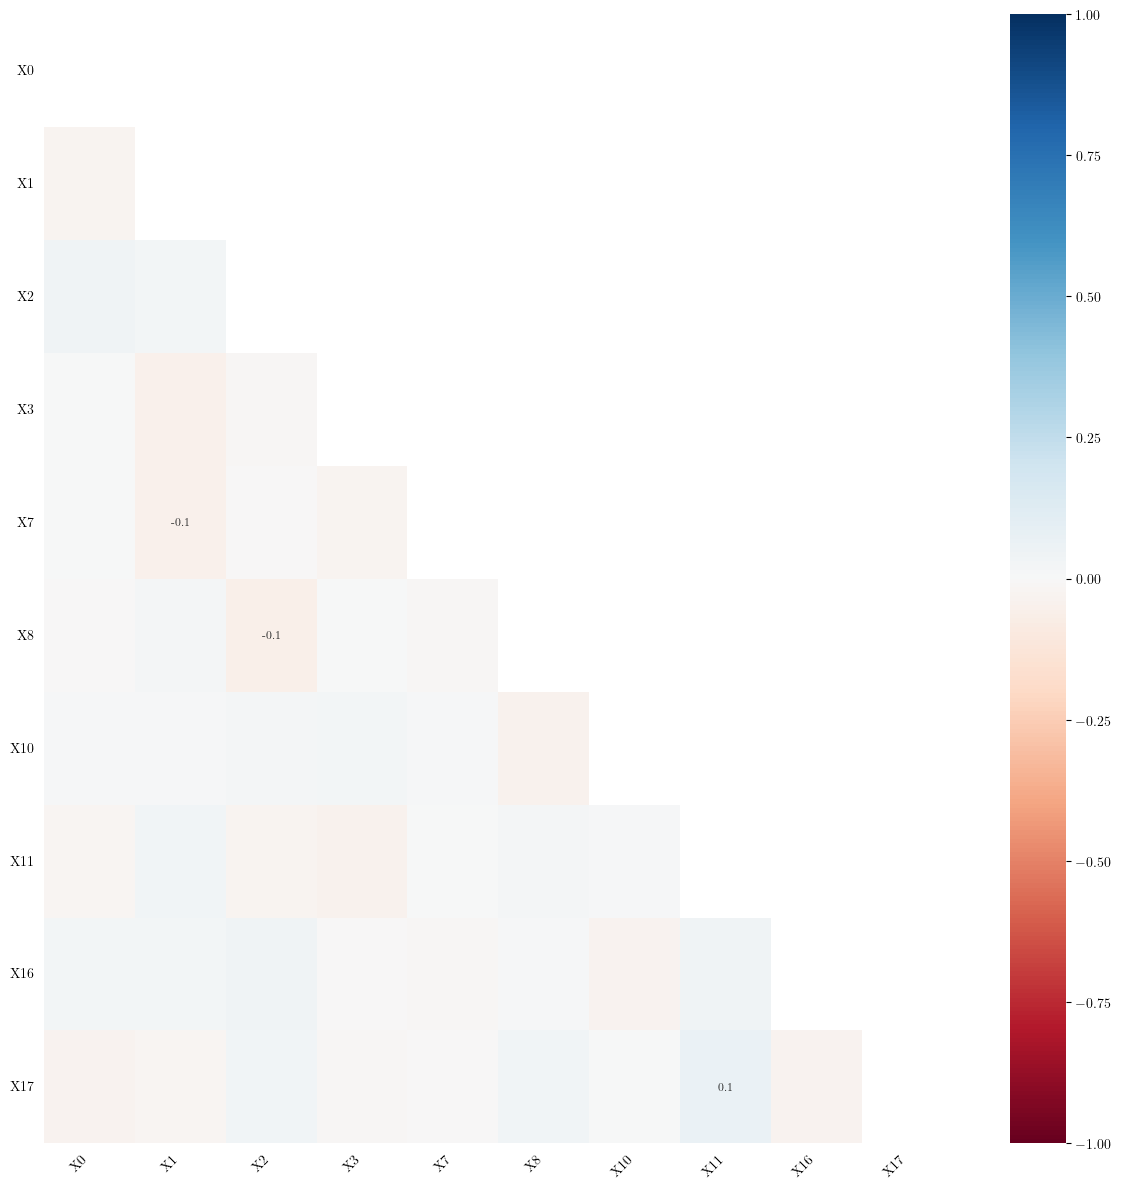

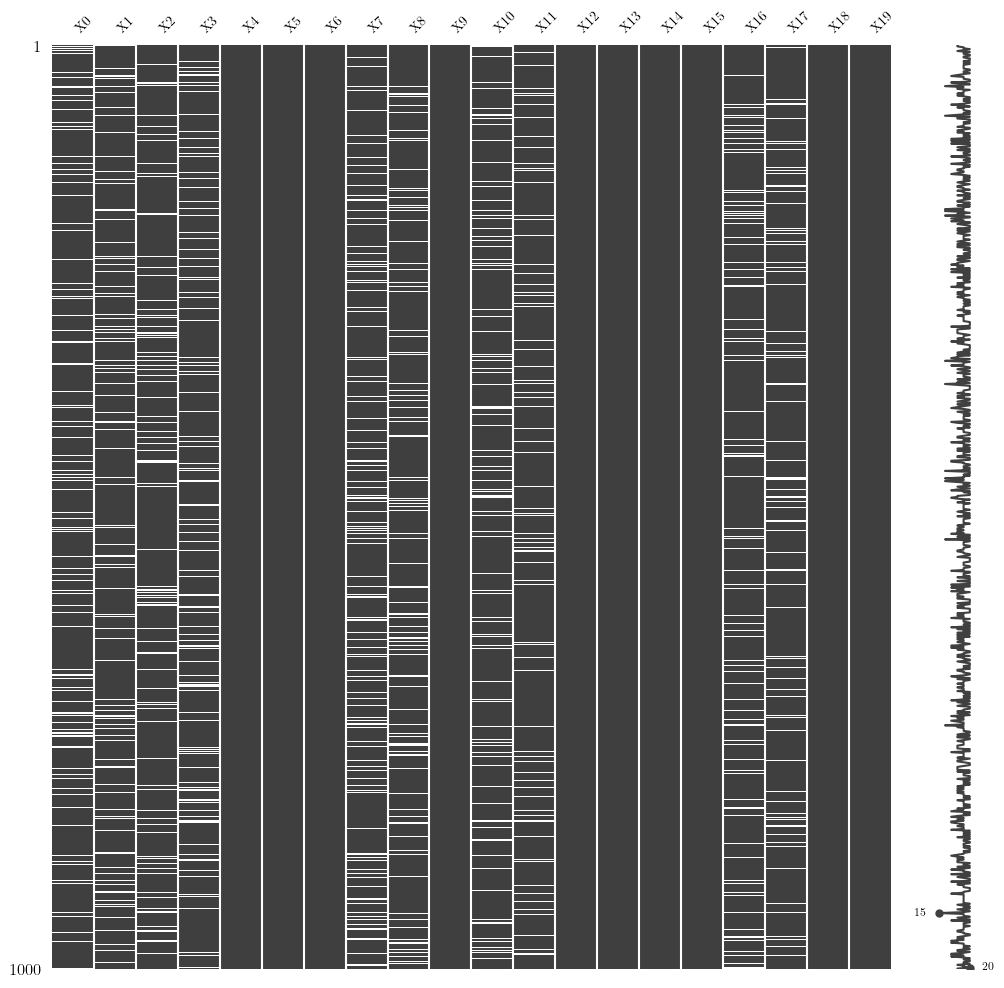

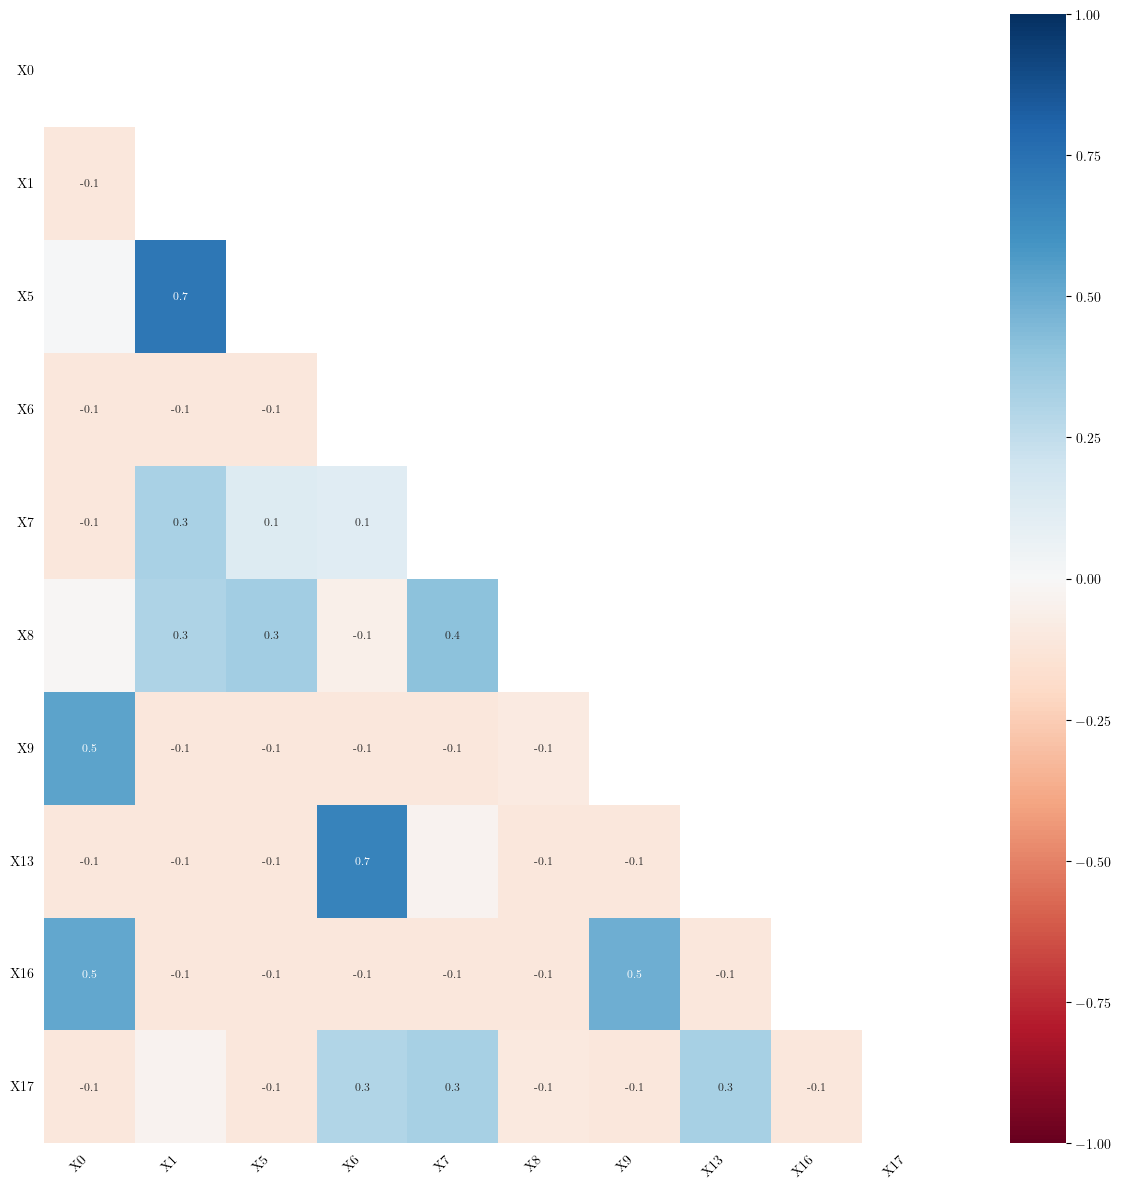

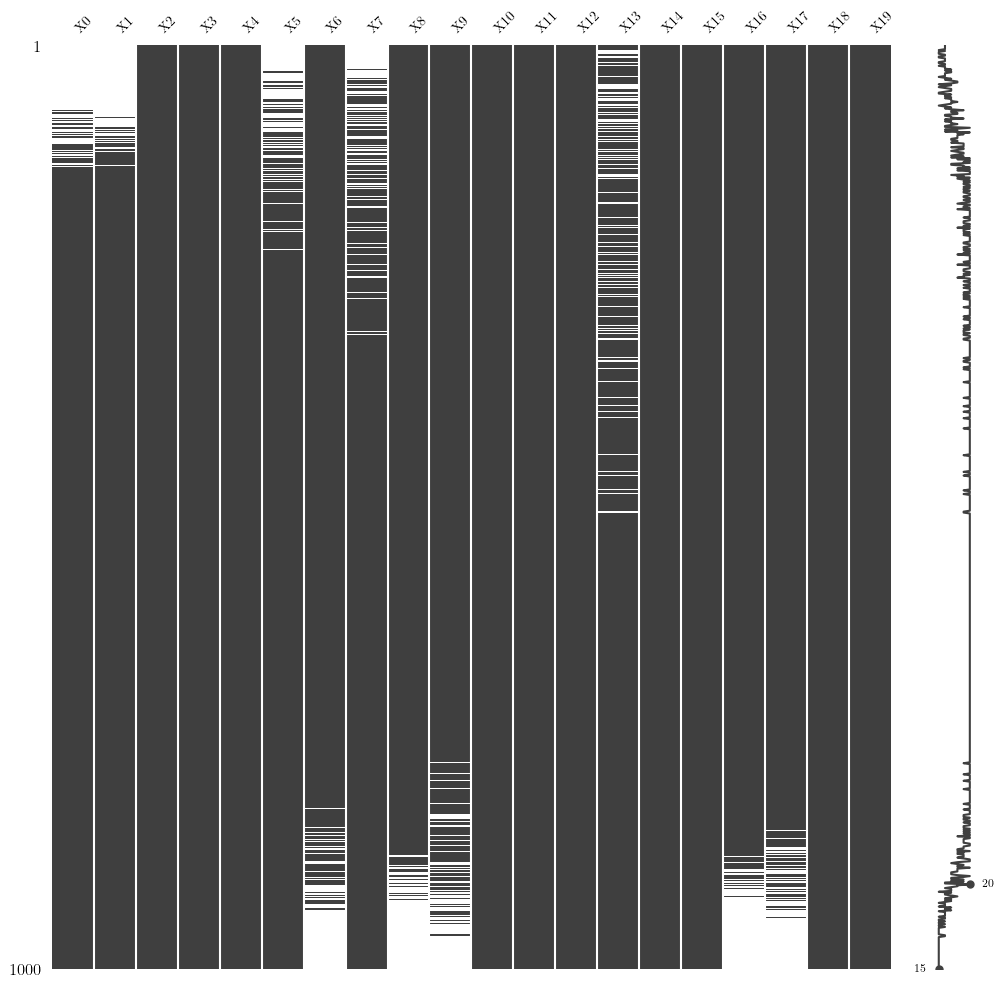

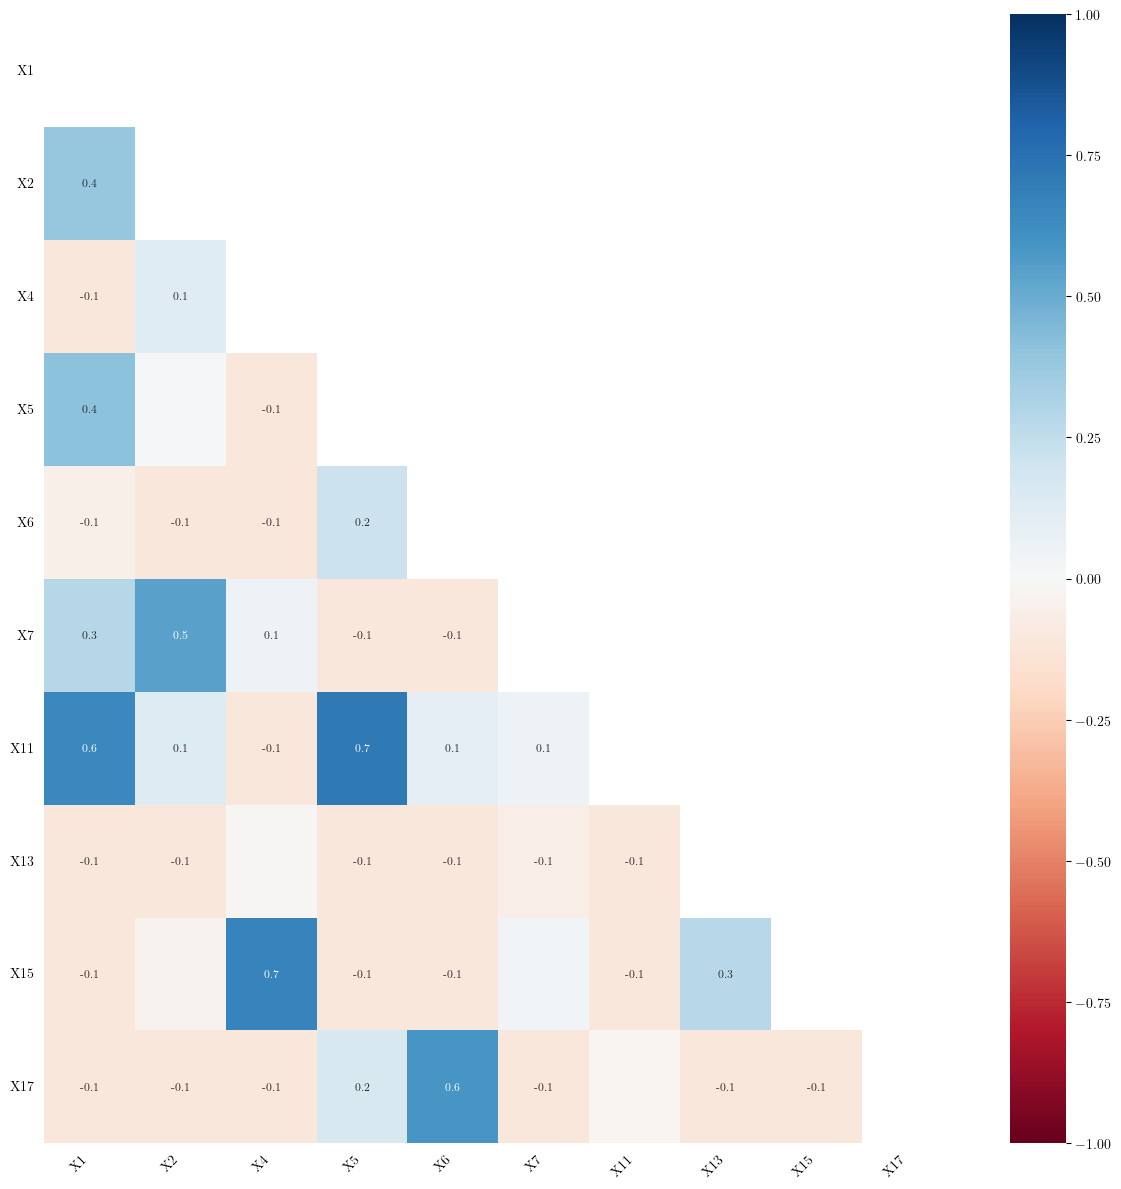

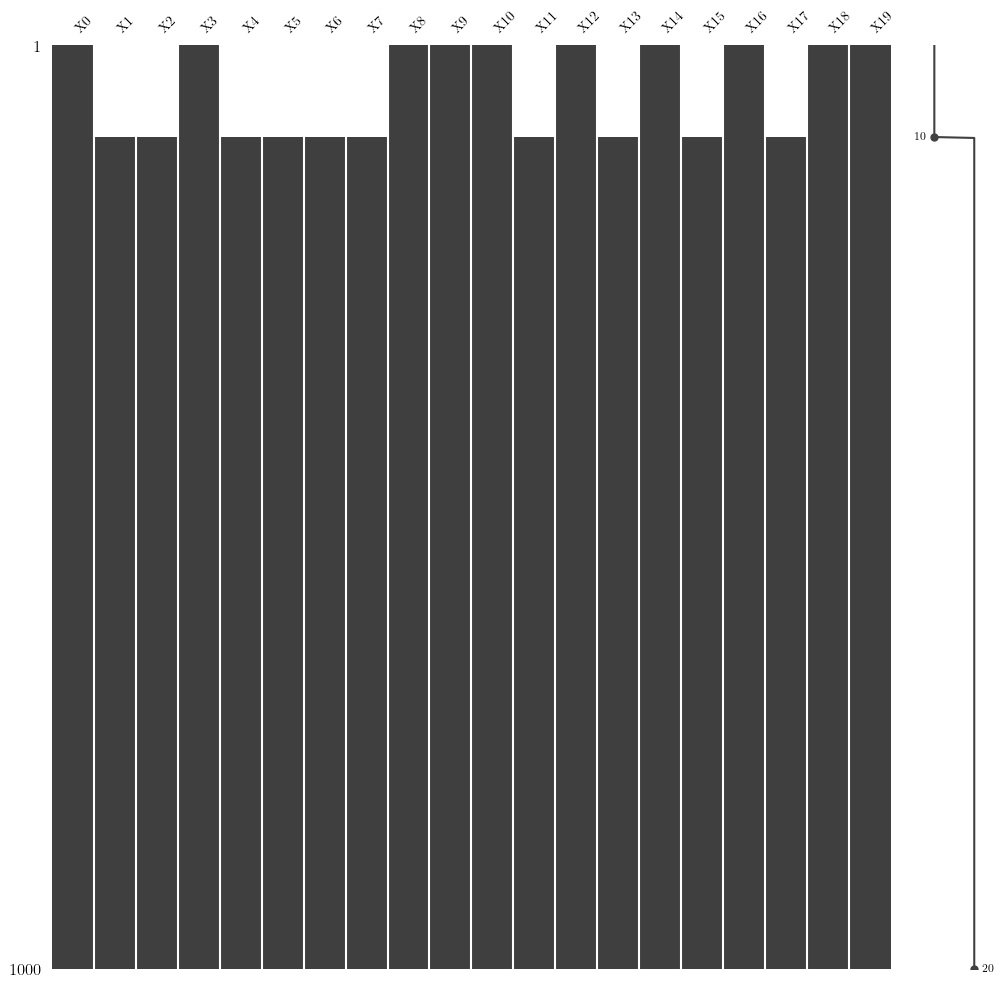

In [9]:
import missingno as msno

missing_rate = 5
dataset = preprocess(torus(), TORUS)
data_miss = {
    MCAR: MISSINGNESS[MCAR][FUNCTION](dataset[DATA], dataset[TARGET], missing_rate, SEEDS[0]),
    MAR: MISSINGNESS[MAR][FUNCTION](dataset[DATA], dataset[TARGET], missing_rate, SEEDS[0]),
    MNAR: MISSINGNESS[MNAR][FUNCTION](dataset[DATA], dataset[TARGET], missing_rate, SEEDS[0])
}

for key, data_missing in data_miss.items():
    plot_missing_data(data_missing, dataset[DATA], 'heatmap')
    data_sorted_columns = data_missing.copy()
    original_sorted_columns = dataset[DATA].copy()

    for col in dataset[DATA].columns:
        sorted_indices = dataset[DATA][col].sort_values().index
        original_sorted_values = dataset[DATA][col].loc[sorted_indices].values
        sorted_missing_values = data_missing[col].loc[sorted_indices].values
        data_sorted_columns[col] = sorted_missing_values
        original_sorted_columns[col] = original_sorted_values

    plot_missing_data(data_sorted_columns, dataset[DATA], 'normal')

## Distance vs Missingrate
Plots how distances between original and imputed data change with increasing missing rates, helping to verify whether the data exhibits expected natural characteristics.

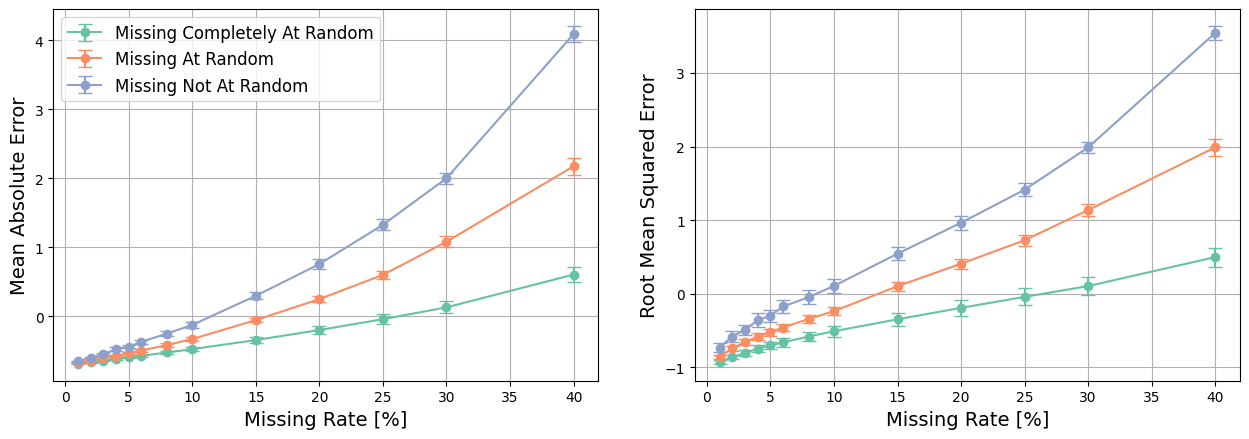

In [5]:
df = group_results(
    csv=COMPARISON_METRICS,
    group=[DATASET, MISSINGNESS_TYPE, MISSING_RATE],
    metrics=COLLECTIONS[METRIC],
    filter=[IMPUTATION_METHOD, KNN]
)

for metric in COLLECTIONS[METRIC]:
    df[metric] = StandardScaler().fit_transform(df[[metric]])

fig, axes = setup_figure(
    rows=1,
    cols=len(COLLECTIONS[METRIC])
)
axes = axes.flatten()

for i, metric in enumerate(COLLECTIONS[METRIC]):
    ax = axes[i]

    for mt in COLLECTIONS[MISSINGNESS_TYPE]:
        mean, sem = compute_mean_sem(
            type=MISSINGNESS_TYPE,
            data=df,
            group=MISSING_RATE, 
            metric=metric,
            filter=(df[MISSINGNESS_TYPE] == mt)
        )
        plot_data(
            type=MISSINGNESS_TYPE,
            ax=ax, mean=mean, sem=sem,
            label=LABEL[mt],
            color=plt.get_cmap(COLOR_MAP[MISSINGNESS_TYPE])(COLLECTIONS[MISSINGNESS_TYPE].index(mt))
        )
    
    format_axes(
        type=MISSINGNESS_TYPE, 
        ax=ax,
        x_label=LABEL[MISSING_RATE],
        y_label=LABEL[metric],
        legend=i==0
    )
plot()

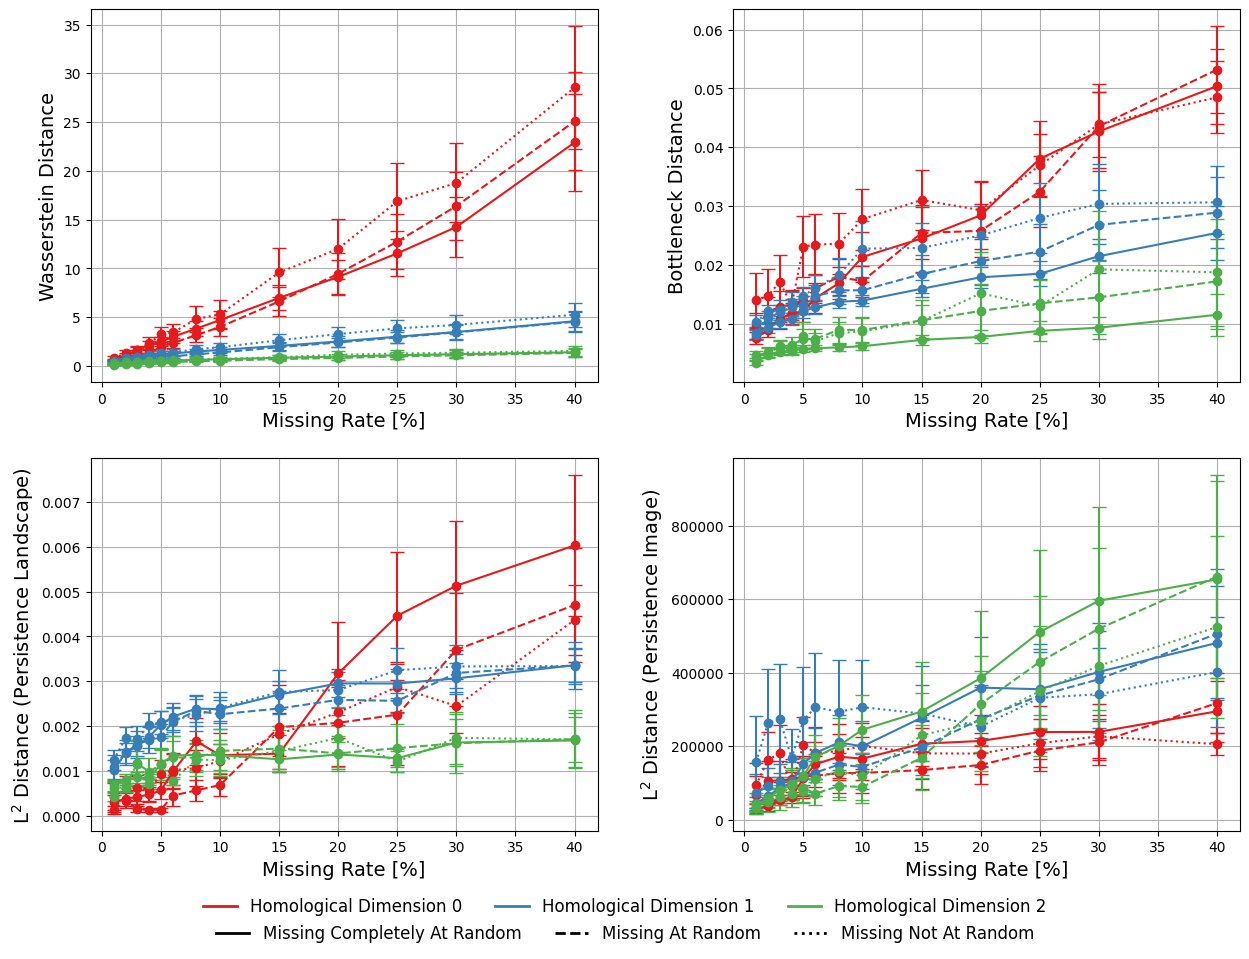

In [6]:
df = group_results(
    csv=IMPACT_MISSINGNESS,
    group=[DATASET, MISSINGNESS_TYPE, DIMENSION, MISSING_RATE],
    metrics=COLLECTIONS[TDA_METRIC]
)

fig, axes = setup_figure(
    cells=len(COLLECTIONS[TDA_METRIC])
)
axes = axes.flatten()

for i, metric in enumerate(COLLECTIONS[TDA_METRIC]):
    ax = axes[i]

    for dim in DIMENSIONS:
        for j, mtype in enumerate(COLLECTIONS[MISSINGNESS_TYPE]):
            mask = (df[DIMENSION] == dim) & (df[MISSINGNESS_TYPE] == mtype)
            mean, sem = compute_mean_sem(
                type=MISSING_RATE,
                data=df,
                group=MISSING_RATE, 
                metric=metric,
                filter=mask
            )
            plot_data(
                type=MISSING_RATE,
                ax=ax,
                mean=mean,
                sem=sem,
                label=f'{LABEL[DIMENSION]} {dim}, {LABEL[MISSINGNESS_TYPE]} {mtype}',
                color=plt.get_cmap(COLOR_MAP[DIMENSION])(dim),
                linestyle=COLLECTIONS[LINESTYLE][j % len(COLLECTIONS[LINESTYLE])]
            )
    
    format_axes(
        type=MISSING_RATE, 
        ax=ax,
        x_label=LABEL[MISSING_RATE],
        y_label=LABEL[metric],
    )

multi_legend(fig)
plot()


## Calculate Persistence Intervals

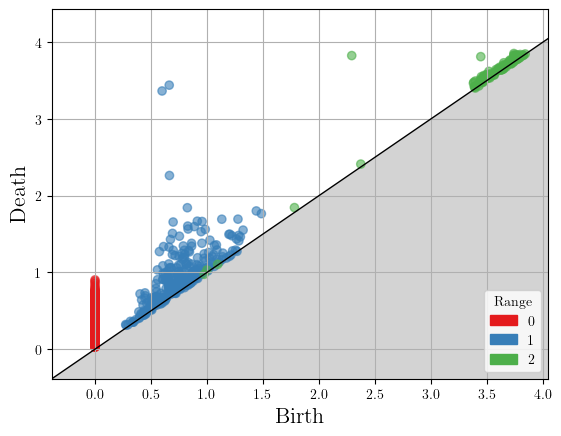

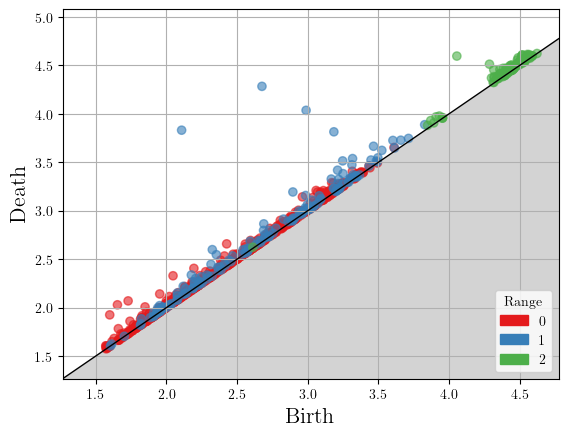

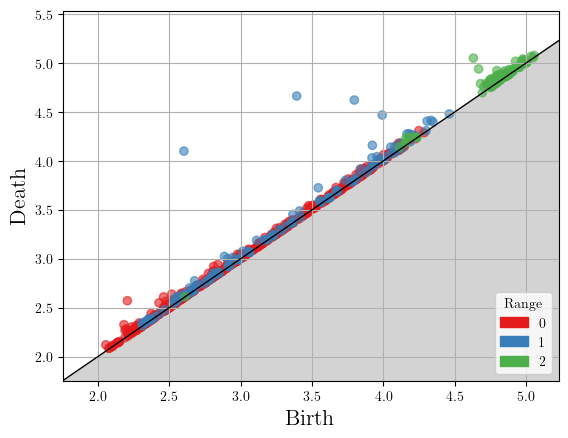

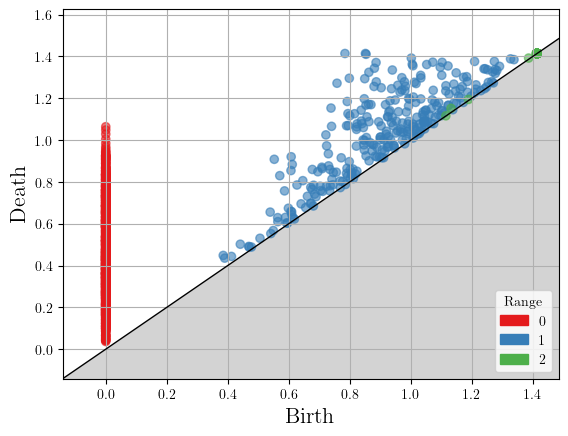

In [7]:
dataset = preprocess(torus(), TORUS)
persistence_intervals = {
    VR: TDA[VR][FUNCTION](dataset[DATA]),
    DTMS: TDA[DTMS][FUNCTION](dataset[DATA]),
    DTMC: TDA[DTMC][FUNCTION](dataset[DATA]),
    KD: TDA[KD][FUNCTION](dataset[DATA])
}
for tda_method in COLLECTIONS[TDA_METHOD]:
    plot_persistence_diagram(persistence_intervals[tda_method])

## Normalized Persistence Intervals

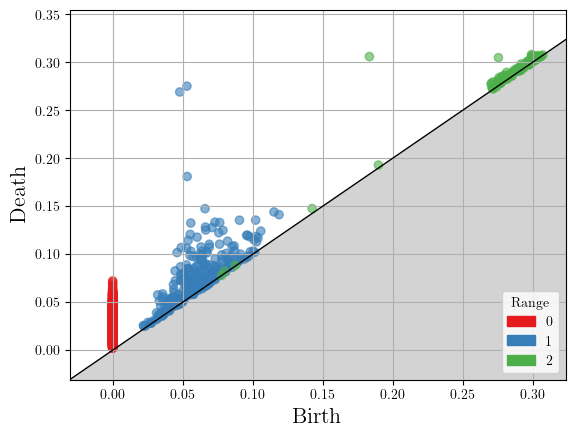

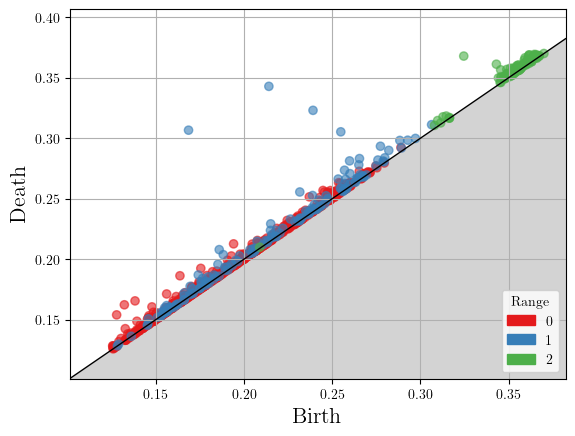

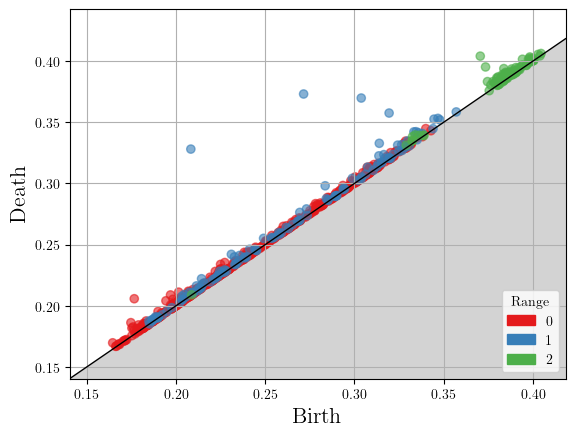

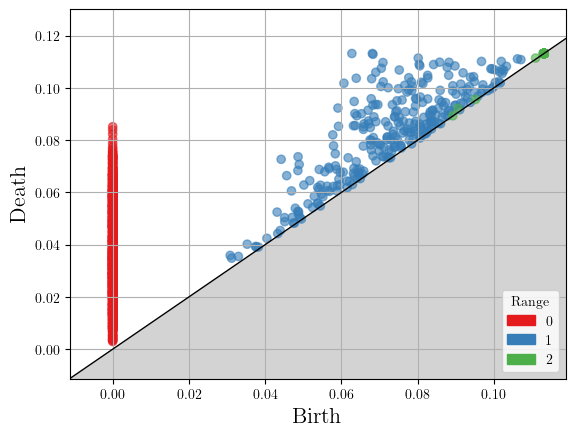

In [8]:
normalized_persistence_intervals = {
    VR: normalize_by_diameter(persistence_intervals[VR], dataset[DATA]),
    DTMS: normalize_by_diameter(persistence_intervals[DTMS], dataset[DATA]),
    DTMC: normalize_by_diameter(persistence_intervals[DTMC], dataset[DATA]),
    KD: normalize_by_diameter(persistence_intervals[KD], dataset[DATA]),
}

for tda_method in COLLECTIONS[TDA_METHOD]:
    plot_persistence_diagram(normalized_persistence_intervals[tda_method])